In [1]:
import gdown
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Google Drive ID for the Parquet file
file_id = "1gLPWgUGtRb371Gpv5O8t5j95lthNjELg"
url = f"https://drive.google.com/uc?id={file_id}"
output = "sm2_public_dataset.parquet"

# Download
gdown.download(url, output, quiet=False)

# Load
df = pd.read_parquet(output)

Downloading...
From: https://drive.google.com/uc?id=1gLPWgUGtRb371Gpv5O8t5j95lthNjELg
To: /content/sm2_public_dataset.parquet
100%|██████████| 1.29M/1.29M [00:00<00:00, 44.6MB/s]


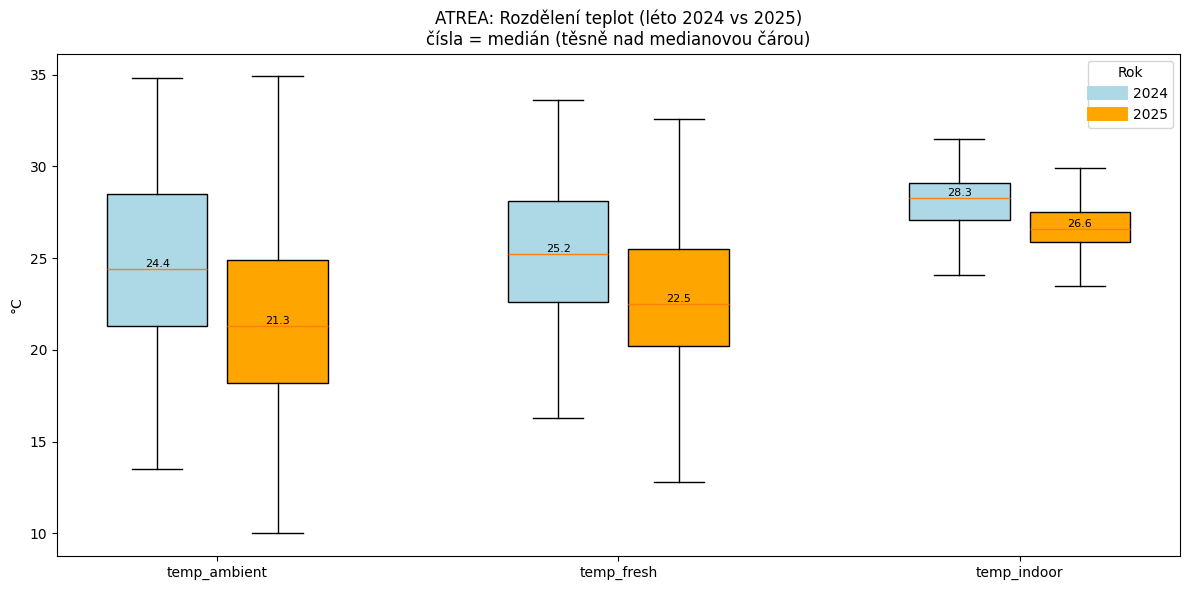

In [2]:
# ============== ATREA: Léto 2024 vs 2025 — porovnávací boxplot + čísla mediánů těsně nad čarou ==============
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def summer_utc_bounds(year: int, tz: str = "Europe/Prague"):
    start_local = pd.Timestamp(f"{year}-06-01 00:00:00", tz=tz)
    end_local   = pd.Timestamp(f"{year}-08-31 23:59:59", tz=tz)
    return start_local.tz_convert("UTC"), end_local.tz_convert("UTC")

# --- data ---
assert "df" in globals(), "Please load the DataFrame `df` first."
if df.columns.duplicated().any():
    df = df.loc[:, ~df.columns.duplicated()].copy()

atrea = df[(df["source"]=="Atrea") & (df["data_key"].isin(["temp_ambient","temp_fresh","temp_indoor"]))].copy()
atrea["time"] = pd.to_datetime(atrea["time"], utc=True, errors="coerce")
atrea = atrea.dropna(subset=["time","data_value"])

keys  = ["temp_ambient","temp_fresh","temp_indoor"]
years = [2024, 2025]

# --- long data (léto za daný rok) ---
rows = []
for key in keys:
    s_all = atrea[atrea["data_key"]==key].set_index("time")["data_value"].sort_index()
    for yr in years:
        start_utc, end_utc = summer_utc_bounds(yr)
        s = s_all.loc[(s_all.index>=start_utc) & (s_all.index<=end_utc)].dropna()
        rows.extend({"data_key": key, "year": yr, "data_value": float(v)} for v in s.values)

boxdf = pd.DataFrame(rows)
if boxdf.empty:
    raise ValueError("Pro zadané roky/klíče není k dispozici žádná letní data z Atrea.")

# --- příprava pro boxplot ---
positions, data, colors = [], [], []
offset = 0.3  # rozestup 2024 vs 2025 v rámci klíče
for i, key in enumerate(keys):
    vals24 = boxdf[(boxdf["data_key"]==key) & (boxdf["year"]==2024)]["data_value"].values
    vals25 = boxdf[(boxdf["data_key"]==key) & (boxdf["year"]==2025)]["data_value"].values
    positions.extend([i*2 - offset, i*2 + offset])
    data.extend([vals24, vals25])
    colors.extend(["lightblue", "orange"])  # uživatel chce jiné barvy pro roky

# --- kreslení ---
plt.figure(figsize=(12,6))
bp = plt.boxplot(data, positions=positions, widths=0.5, patch_artist=True, showfliers=False)
for patch, c in zip(bp["boxes"], colors):
    patch.set_facecolor(c)

# --- čísla mediánů: vyčteme přímo z vykreslených median lines a posuneme o pár bodů vzhůru ---
# bp["medians"] is a list of Line2D; each has xdata=[x0,x1], ydata=[y,y]
for med_line in bp["medians"]:
    x0, x1 = med_line.get_xdata()
    y0, y1 = med_line.get_ydata()
    x_mid = (x0 + x1) / 2.0
    y_med = (y0 + y1) / 2.0
    # text o 2 body nad čárou (nezávislé na měřítku osy)
    plt.annotate(f"{y_med:.1f}",
                 xy=(x_mid, y_med),
                 xytext=(0, 0), textcoords="offset points",
                 ha="center", va="bottom",
                 fontsize=8, color="black", clip_on=False, zorder=3)

# X axis and legend
plt.xticks([i*2 for i in range(len(keys))], keys)
plt.ylabel("°C")
plt.title("ATREA: Rozdělení teplot (léto 2024 vs 2025)\nčísla = medián (těsně nad medianovou čárou)")
handles = [plt.Line2D([0],[0], color="lightblue", lw=10),
           plt.Line2D([0],[0], color="orange", lw=10)]
plt.legend(handles, ["2024","2025"], title="Rok")

plt.tight_layout()
plt.show()

/tmp/ipython-input-1630000061.py:129: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20" if len(sections_all) > 10 else "tab10", len(sections_all))


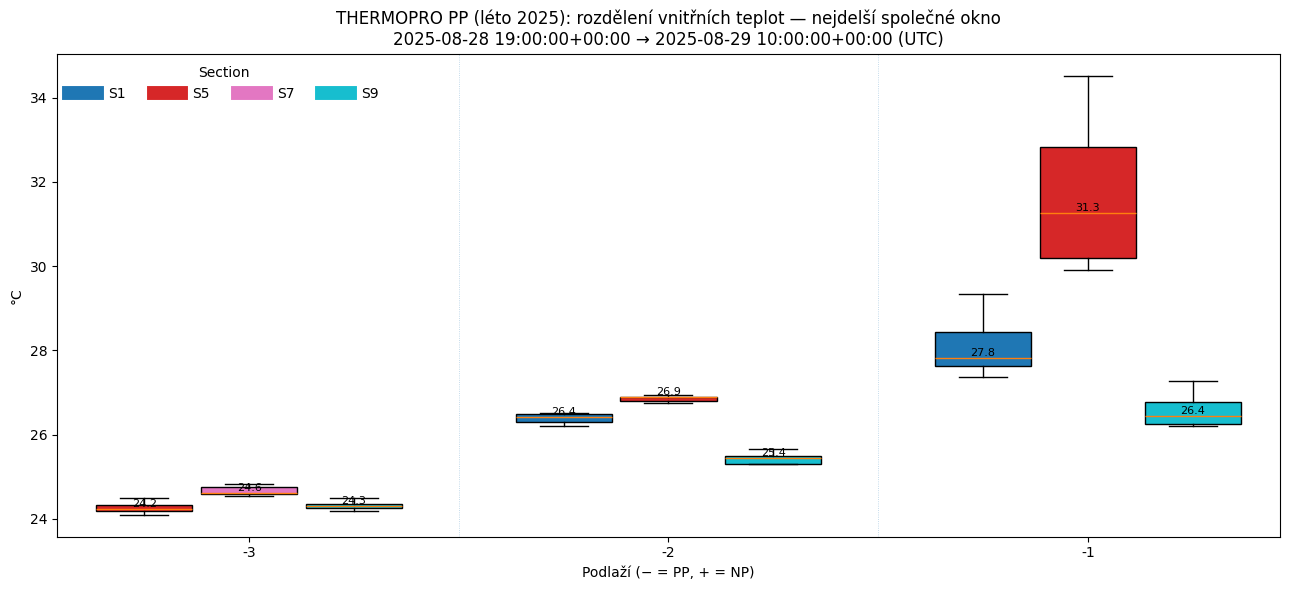

/tmp/ipython-input-1630000061.py:129: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20" if len(sections_all) > 10 else "tab10", len(sections_all))


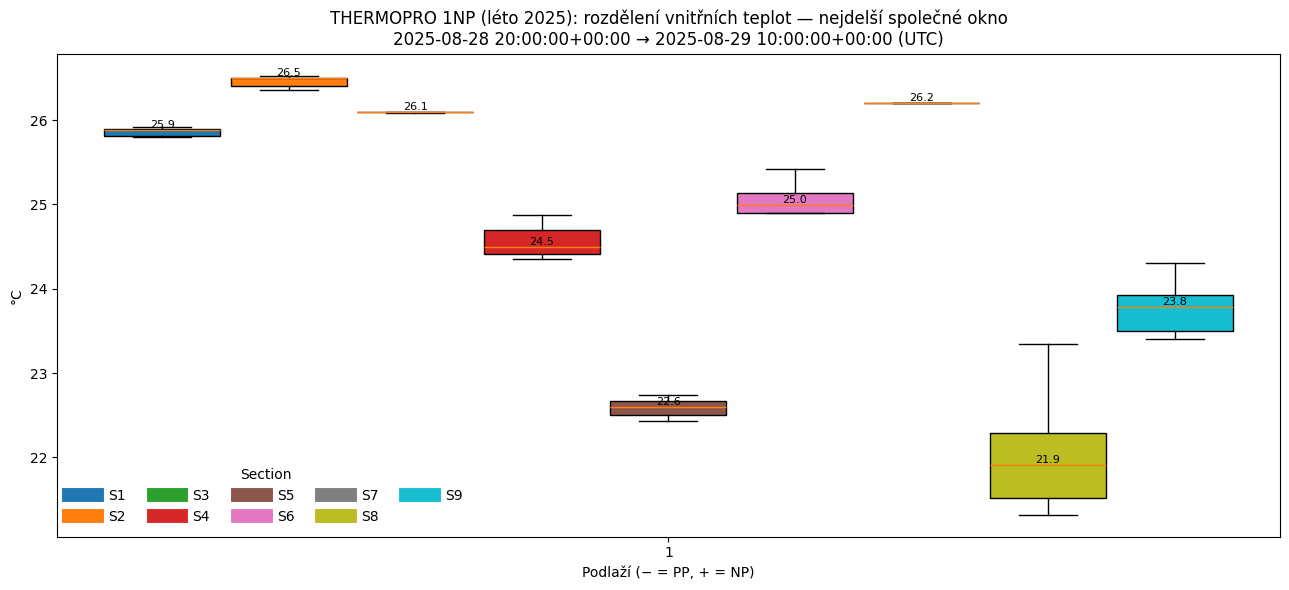

/tmp/ipython-input-1630000061.py:129: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20" if len(sections_all) > 10 else "tab10", len(sections_all))


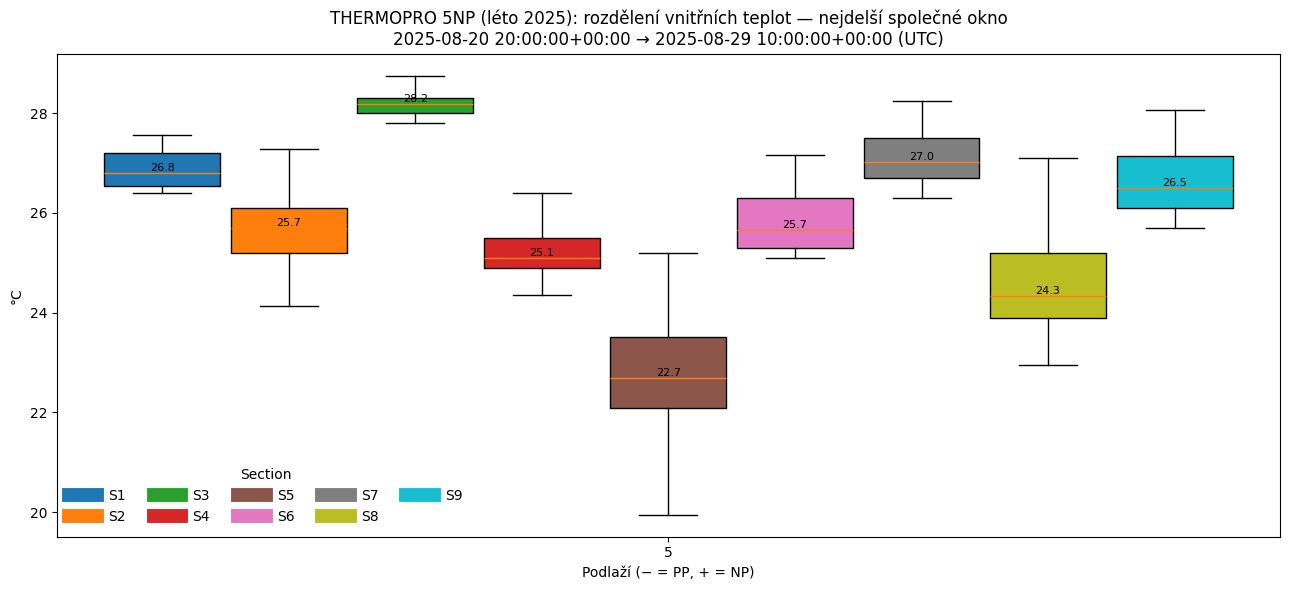

In [3]:
# ====================== THERMOPRO — PP, 1NP, 5NP ======================
# - Finds the longest window with full coverage of requested combinations (allowing 1 missing)
# - 3 charts: PP (3PP/2PP/1PP), 1NP, 5NP
# - Larger boxes, colors = section, median printed directly on the median line (xytext=(0, 0))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

# ---------------- Params ----------------
YEAR = 2025
LIMIT_TO_SUMMER = True       # True = omezit hledání okna jen na léto daného roku
TZ = "Europe/Prague"

def summer_bounds_utc(year: int, tz: str = TZ):
    start_local = pd.Timestamp(f"{year}-06-01 00:00:00", tz=tz)
    end_local   = pd.Timestamp(f"{year}-08-31 23:59:59", tz=tz)
    return start_local.tz_convert("UTC"), end_local.tz_convert("UTC")

# ---------------- Data prep ----------------
assert "df" in globals(), "Please load the DataFrame `df` first."
if df.columns.duplicated().any():
    df = df.loc[:, ~df.columns.duplicated()].copy()

thermo = df[(df["source"]=="ThermoPro") & (df["data_key"]=="temp_indoor")].copy()
thermo["time"] = pd.to_datetime(thermo["time"], utc=True, errors="coerce")
thermo = thermo.dropna(subset=["time","data_value","location"]).sort_values("time")

# Derive zone / floor / section from `location` (e.g., "1NP-S5", "5NP-S1", "2PP-S9")
m = thermo["location"].astype(str).str.extract(r'(?P<num>\d+)(?P<zone>NP|PP)-(?P<section>S\d+)', expand=True)
thermo["zone_derived"] = m["zone"].where(m["zone"].notna(), "VZT")
lvl = pd.to_numeric(m["num"], errors="coerce")
lvl_signed = lvl.copy()
lvl_signed[m["zone"]=="PP"] = -lvl_signed[m["zone"]=="PP"]  # PP záporně, NP kladně
thermo["floor_level_derived"] = lvl_signed
thermo["section_derived"] = m["section"]
thermo = thermo.dropna(subset=["floor_level_derived","section_derived"])

# Optional restriction to summer
if LIMIT_TO_SUMMER:
    s_utc, e_utc = summer_bounds_utc(YEAR)
    thermo = thermo[(thermo["time"] >= s_utc) & (thermo["time"] <= e_utc)].copy()

# ---------------- Helpers ----------------
def key_ranges(df: pd.DataFrame, keys):
    """
    Vrátí dict {(floor, section): (tmin, tmax)} jen pro klíče, které v df existují.
    """
    present = {}
    for (fl, sec) in keys:
        g = df[(df["floor_level_derived"]==fl) & (df["section_derived"]==sec)]
        if not g.empty:
            present[(fl, sec)] = (g["time"].min(), g["time"].max())
    return present

def intersect_interval(ranges_dict, use_keys):
    """
    Průnik časových intervalů pro vybrané klíče. Vrací (tmin, tmax) nebo (None, None) pokud prázdný.
    """
    tmins, tmaxs = [], []
    for k in use_keys:
        tmin, tmax = ranges_dict[k]
        tmins.append(tmin); tmaxs.append(tmax)
    tmin_all = max(tmins) if tmins else None
    tmax_all = min(tmaxs) if tmaxs else None
    if (tmin_all is None) or (tmax_all is None) or (tmin_all > tmax_all):
        return None, None
    return tmin_all, tmax_all

def find_longest_common_window(df: pd.DataFrame, required_keys, allow_missing=1):
    """
    Najde nejdelší průnik časových intervalů pro požadované (floor, section).
    - allow_missing = max počet kombinací, které smějí chybět (celkem: fyzicky chybět NEBO být „upuštěny“)
    Vrací (best_tmin, best_tmax, dropped_key_or_None, used_keys_set).
    """
    ranges = key_ranges(df, required_keys)
    existing_keys = set(ranges.keys())
    missing = [k for k in required_keys if k not in existing_keys]

    # if more than allow_missing are missing at the start → fail
    if len(missing) > allow_missing:
        return None, None, None, set()

    # candidates: (no drop) + optionally drop one existing combination if we have room
    candidates = []

    # varianta bez dropu (pokud se vejdeme do tolerance chybějících)
    base_keys = [k for k in required_keys if k in existing_keys]
    tmin, tmax = intersect_interval(ranges, base_keys) if base_keys else (None, None)
    if (tmin is not None) and (allow_missing - len(missing) >= 0):
        candidates.append((tmin, tmax, None, set(base_keys)))

    # if we still have slack (i.e., missing < allow_missing), try dropping one existing combination
    if len(missing) < allow_missing:
        for kdrop in base_keys:
            use_keys = [k for k in base_keys if k != kdrop]
            if not use_keys:
                continue
            tmin2, tmax2 = intersect_interval(ranges, use_keys)
            if tmin2 is not None:
                candidates.append((tmin2, tmax2, kdrop, set(use_keys)))

    if not candidates:
        return None, None, None, set()

    # vyber nejdelší interval
    best = max(candidates, key=lambda c: (c[1]-c[0]))
    return best  # (tmin, tmax, dropped_key, used_keys)

def plot_boxes(df: pd.DataFrame, required_keys, title_prefix, allow_missing=1, bigger=True):
    """
    - Najde nejdelší okno podle required_keys
    - Vykreslí boxy: skupiny = podlaží, v rámci skupiny sekce (barvy konzistentní)
    - Medián vypíše na medianovou čáru (xytext=(0,0))
    """
    tmin, tmax, dropped, used_keys = find_longest_common_window(df, required_keys, allow_missing=allow_missing)
    if tmin is None:
        print(f"{title_prefix}: nenašlo se přijatelné okno (i s tolerancí {allow_missing}).")
        return

    dfw = df[(df["time"] >= tmin) & (df["time"] <= tmax)].copy()

    # floors actually present in the window
    floors = sorted(dfw["floor_level_derived"].unique())
    # sections present in the window (sorted by number)
    sections_all = sorted(dfw["section_derived"].unique(), key=lambda s: int(re.sub(r"\D","",s) or 0))

    cmap = plt.cm.get_cmap("tab20" if len(sections_all) > 10 else "tab10", len(sections_all))
    color_map = {sec: cmap(i) for i, sec in enumerate(sections_all)}

    # spacings and sizes (larger boxes)
    group_spacing = 2.4 if bigger else 1.8
    box_spacing   = 0.30 if bigger else 0.15
    box_width     = 0.55 if bigger else 0.25

    positions, data, colors = [], [], []
    xticks, xticklabels = [], []

    for g_idx, fl in enumerate(sorted(floors)):
        base_x = g_idx * group_spacing
        # sections we want for the given floor (from required_keys), but only those actually present in the window
        sec_required = sorted({sec for f, sec in required_keys if f == fl}, key=lambda s: int(re.sub(r"\D","",s) or 0))
        sec_here = [sec for sec in sec_required if sec in sections_all]
        if len(sec_here) == 0:
            continue

        k = len(sec_here)
        offsets = (np.arange(k) - (k-1)/2.0) * (box_spacing*2)

        for off, sec in zip(offsets, sec_here):
            vals = dfw[(dfw["floor_level_derived"]==fl) & (dfw["section_derived"]==sec)]["data_value"].values
            if vals.size == 0:
                continue
            positions.append(base_x + off)
            data.append(vals)
            colors.append(color_map[sec])

        xticks.append(base_x)
        xticklabels.append(f"{int(fl)}")

    # plotting
    fig, ax = plt.subplots(figsize=(13,6))
    if len(data) == 0:
        print(f"{title_prefix}: v okně {tmin}–{tmax} nejsou žádná data pro požadované kombinace.")
        return

    bp = ax.boxplot(data, positions=positions, widths=box_width, patch_artist=True, showfliers=False)

    for patch, c in zip(bp["boxes"], colors):
        patch.set_facecolor(c)

    # median as a number directly on the median line (xytext=(0,0))
    for med_line in bp["medians"]:
        x0, x1 = med_line.get_xdata(); y0, y1 = med_line.get_ydata()
        x_mid = (x0 + x1) / 2.0; y_med = (y0 + y1) / 2.0
        ax.annotate(f"{y_med:.1f}", xy=(x_mid, y_med),
                    xytext=(0, 0), textcoords="offset points",
                    ha="center", va="bottom", fontsize=8, color="black", clip_on=False, zorder=3)

    # separators between groups
    for g_idx in range(len(xticks)-1):
        x_sep = (xticks[g_idx] + xticks[g_idx+1]) / 2.0
        ax.axvline(x_sep, linestyle=":", linewidth=0.6, alpha=0.35)

    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    ax.set_xlabel("Podlaží (− = PP, + = NP)")
    ax.set_ylabel("°C")

    dropped_txt = ""
    if dropped is not None:
        fl_d, sec_d = dropped
        dropped_txt = f"\n(pokrytí bez 1 kombinace: {int(fl_d)}×{sec_d})"

    ax.set_title(f"{title_prefix}: rozdělení vnitřních teplot — nejdelší společné okno{dropped_txt}\n"
                 f"{tmin} → {tmax} (UTC)")

    # legend of sections
    handles = [plt.Line2D([0],[0], color=color_map[sec], lw=10) for sec in sections_all]
    ax.legend(handles, sections_all, title="Section", ncol=min(5, len(sections_all)), frameon=False)

    fig.tight_layout()
    plt.show()

# ---------------- Required sets per chart ----------------
# PP: floors -3, -2, -1 with given sections
required_PP = [(-3, "S5"), (-3, "S7"), (-3, "S9"),
               (-2, "S1"), (-2, "S5"), (-2, "S9"),
               (-1, "S1"), (-1, "S5"), (-1, "S9")]

# 1NP a 5NP: všechny sekce S1..S9
required_1NP = [(1, f"S{i}") for i in range(1,10)]
required_5NP = [(5, f"S{i}") for i in range(1,10)]

# ---------------- Filtry dat a vykreslení ----------------
# PP data
pp_df = thermo[thermo["zone_derived"]=="PP"].copy()
plot_boxes(pp_df, required_PP, title_prefix=f"THERMOPRO PP (léto {YEAR})", allow_missing=1, bigger=True)

# 1NP
np1_df = thermo[(thermo["zone_derived"]=="NP") & (thermo["floor_level_derived"]==1)].copy()
plot_boxes(np1_df, required_1NP, title_prefix=f"THERMOPRO 1NP (léto {YEAR})", allow_missing=1, bigger=True)

# 5NP
np5_df = thermo[(thermo["zone_derived"]=="NP") & (thermo["floor_level_derived"]==5)].copy()
plot_boxes(np5_df, required_5NP, title_prefix=f"THERMOPRO 5NP (léto {YEAR})", allow_missing=1, bigger=True)